In [1]:
import os
os.chdir("../")

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [2]:
from config import *
from data import *
from train import *
from eval import *
from vital import *
print("using device: ", device)

Random seed set to 333
using device:  cpu


## Customize Configuration

In [3]:
# (customize) configs
overwrite = False
model_name = 'test_succ_inc'
text_config['cl']['die7d'] = True # udpate text_config here if needed
# model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    text_col = 'description_succ_inc',#'ts_description',
    y_col = 'description_succ_inc',
    y_levels = ['High amount of consecutive increases.', 'Low amount of consecutive increases.'],
    y_pred_levels = ['High amount of consecutive increases.', 'Low amount of consecutive increases.'],
    txt2ts_y_cols = ['description_succ_inc'],
    model_name = model_name,
    # downsample = True,
    # downsample_size = 30000,
    embedded_dim = 256,
    batch_size = 512, # Data loader settings
    patience = 100, # Training settings
    num_saves = 10,
    num_epochs = 10,
    init_lr = 5e-5,
    text_config = text_config,
    **{'3d': False}  # Add this line
)
config_dict = get_config_dict()


#  result saving directory
output_dir = './results/'+config_dict['model_name']
model_clip_path = output_dir+'/model_clip.pth' 
eval_clip_path = output_dir+'/evals_clip.pth'
model_path = output_dir+'/model.pth' 
eval_path = output_dir+'/evals.pth'
config_path = output_dir+'/config.pth'

In [4]:
# run preprocess.py to ready the data
with open('main_preprocess.py', 'r') as file:
    exec(file.read())


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1835    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.0s
[Parallel(n_jobs=9)]: Done 2596 tasks      | elapsed:    4.5s
[Parallel(n_jobs=9)]: Done 63298 tasks      | elapsed:   12.1s
[Parallel(n_jobs=9)]: Done 65100 out of 65100 | elapsed:   12.3s finished


replace 'text' with:  description_succ_inc
text
Moderate amount of consecutive increases.    42910
Low amount of consecutive increases.         11838
High amount of consecutive increases.        10352
Name: count, dtype: int64

Sample of patients with positive labels:
TestID
508     8
707     8
1903    8
817     8
1414    7
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    1.9s
[Parallel(n_jobs=9)]: Done 60894 tasks      | elapsed:    6.9s
[Parallel(n_jobs=9)]: Done 61197 out of 61197 | elapsed:    6.9s finished


replace 'text' with:  description_succ_inc
text
Moderate amount of consecutive increases.    36173
Low amount of consecutive increases.         13165
High amount of consecutive increases.        11859
Name: count, dtype: int64
After downsampling:
description_succ_inc
Low amount of consecutive increases.     11838
High amount of consecutive increases.    10352
Name: count, dtype: int64
After downsampling:
description_succ_inc
Low amount of consecutive increases.     6582
High amount of consecutive increases.    5930
Name: count, dtype: int64
final distribution of text prediction
description_succ_inc
Low amount of consecutive increases.     11838
High amount of consecutive increases.    10352
Name: count, dtype: int64
description_succ_inc
Low amount of consecutive increases.     6582
High amount of consecutive increases.    5930
Name: count, dtype: int64


### Customize VITAL Model

In [5]:
# customize model
if overwrite or not os.path.exists(model_path):    
    # check if ts_f_dim is already in the memory
    if 'ts_f_dim' not in locals():
        # just to get the dimension out
        if config_dict['3d']:
            ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], config_dict, text_col_ls = config_dict['text_col_ls'])
        else:
            ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], config_dict)
    
    ts_encoder = None
    ts_decoder = None
    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder,
                    clip_mu = True
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder,
                    clip_mu = True
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    
    train_eval_metrics_ts2txt_list = []
    test_eval_metrics_ts2txt_list = []
    train_eval_metrics_txt2ts_list = []
    test_eval_metrics_txt2ts_list = []
    train_losses = []
    test_losses = []

    
    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    config_dict['model_init'] = model
    torch.save(config_dict, config_path)
    # overwrite = False # reset overwrite to False
else:
    config_dict = torch.load(config_path, map_location=torch.device(device))
    model = config_dict['model_init']
    print(nn_summary(model))
    model.device = device

    

Layer (type:depth-idx)                                            Param #
VITAL                                                             1
├─TSVAEEncoder: 1-1                                               --
│    └─LocalNorm: 2-1                                             --
│    └─Sequential: 2-2                                            --
│    │    └─MultiLSTMEncoder: 3-1                                 11,111,424
│    │    └─LayerNorm: 3-2                                        512
│    │    └─Linear: 3-3                                           131,584
│    │    └─LeakyReLU: 3-4                                        --
│    │    └─LayerNorm: 3-5                                        1,024
│    │    └─Linear: 3-6                                           131,328
│    │    └─LeakyReLU: 3-7                                        --
│    │    └─LayerNorm: 3-8                                        512
│    └─Linear: 2-3                                                65,792
│  

### Train clip for ts and txt encoders first

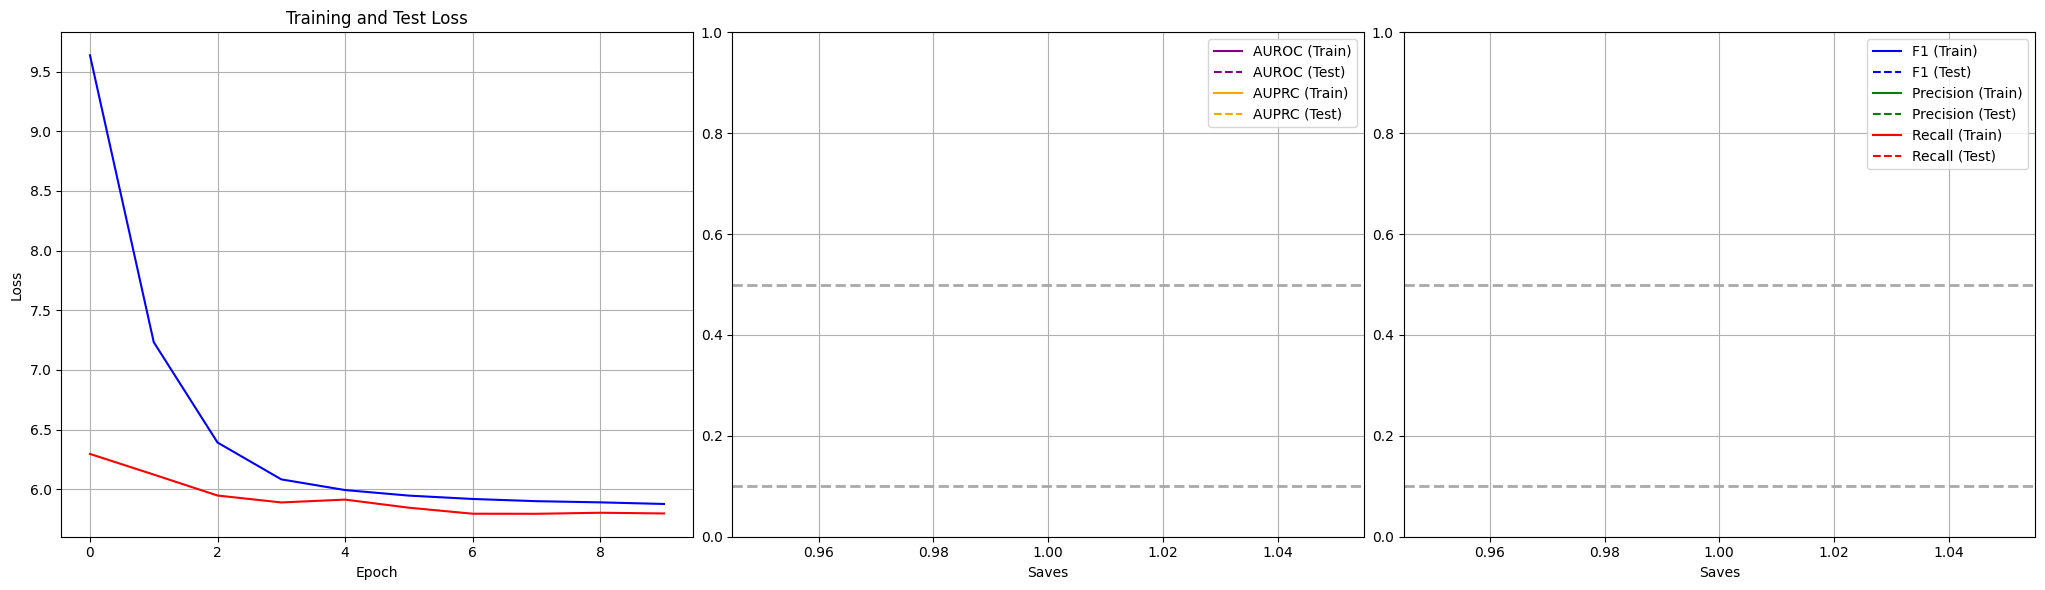

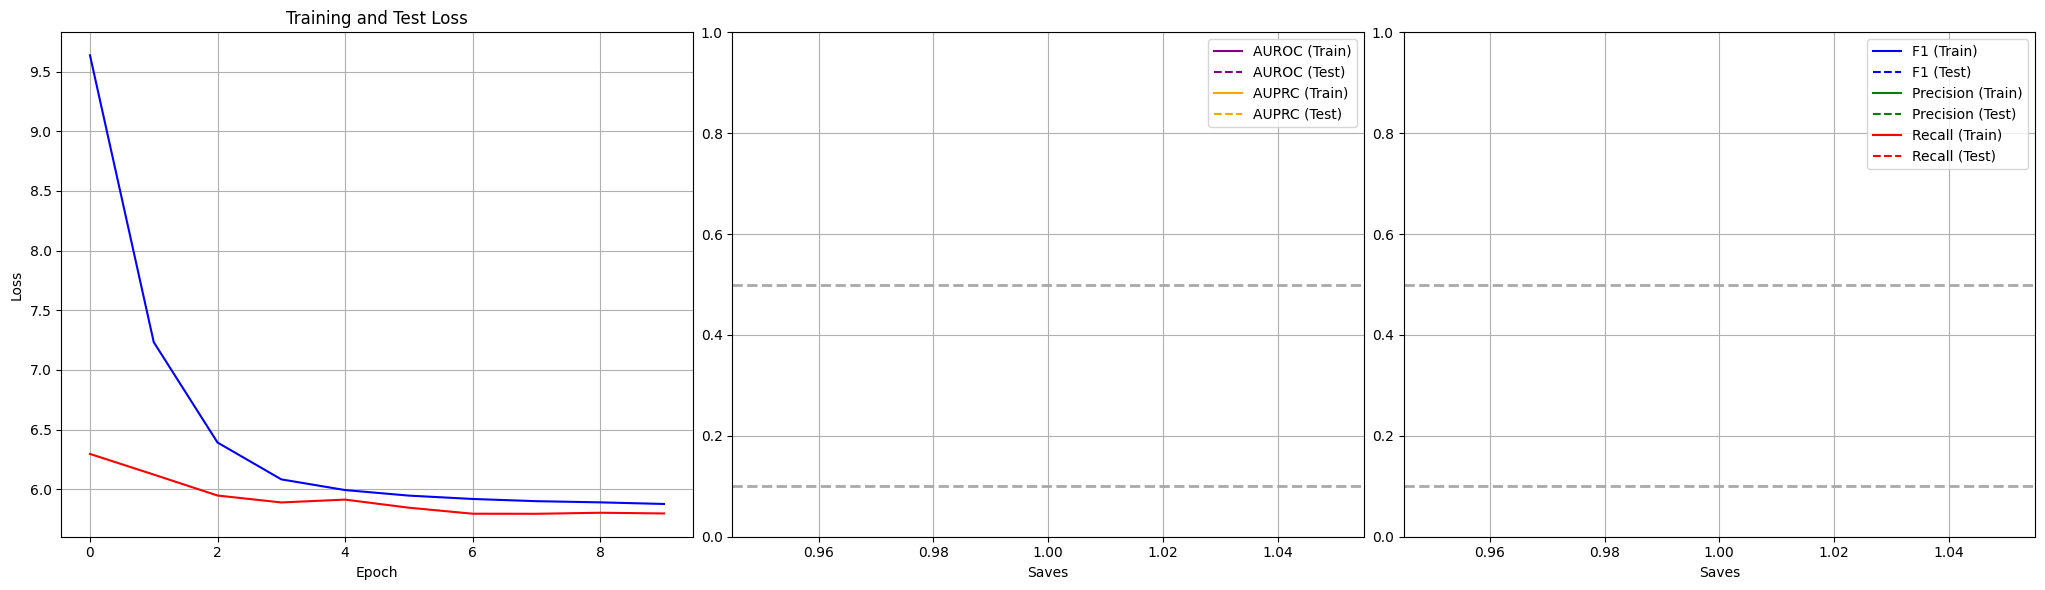

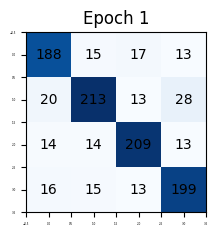

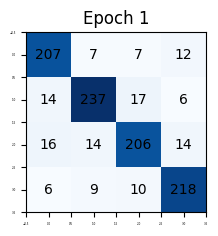

In [6]:
if overwrite or not os.path.exists(model_clip_path):

    # ------------------------- ready training for clip -------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-5,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=100,      
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-4,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=0.0, 
                                end=1.0, 
                                epochs=10000) # for the first 1000 epochs, favor reconstruction more

    
    for i in range(1):  # config_dict['num_saves']
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs'], 
                                                        train_type='clip',
                                                        alpha = 1/1000)
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        if config_dict['3d']:
            train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)

        else:
            train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)

        train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
        test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
        eval_dict_ts2txt = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_ts2txt_list,
                    'test_evals': test_eval_metrics_ts2txt_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
        test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
        eval_dict_txt2ts = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_txt2ts_list,
                    'test_evals': test_eval_metrics_txt2ts_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        # save model and losses
        torch.save(model.state_dict(), model_clip_path)
        torch.save(eval_dict_ts2txt, output_dir+'/evals_clip_ts2txt.pth')
        torch.save(eval_dict_txt2ts, output_dir+'/evals_clip_txt2ts.pth')
    
else:
    model.load_state_dict(torch.load(model_clip_path, map_location=torch.device(device)))
    model.eval()
    eval_dict_ts2txt = torch.load(output_dir+'/evals_clip_ts2txt.pth', map_location=torch.device(device))
    eval_dict_txt2ts = torch.load(output_dir+'/evals_clip_txt2ts.pth', map_location=torch.device(device))
    eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True)
    eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)
    
    

### Continue train vae decoder

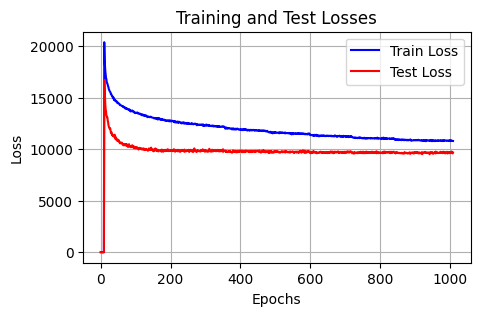

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


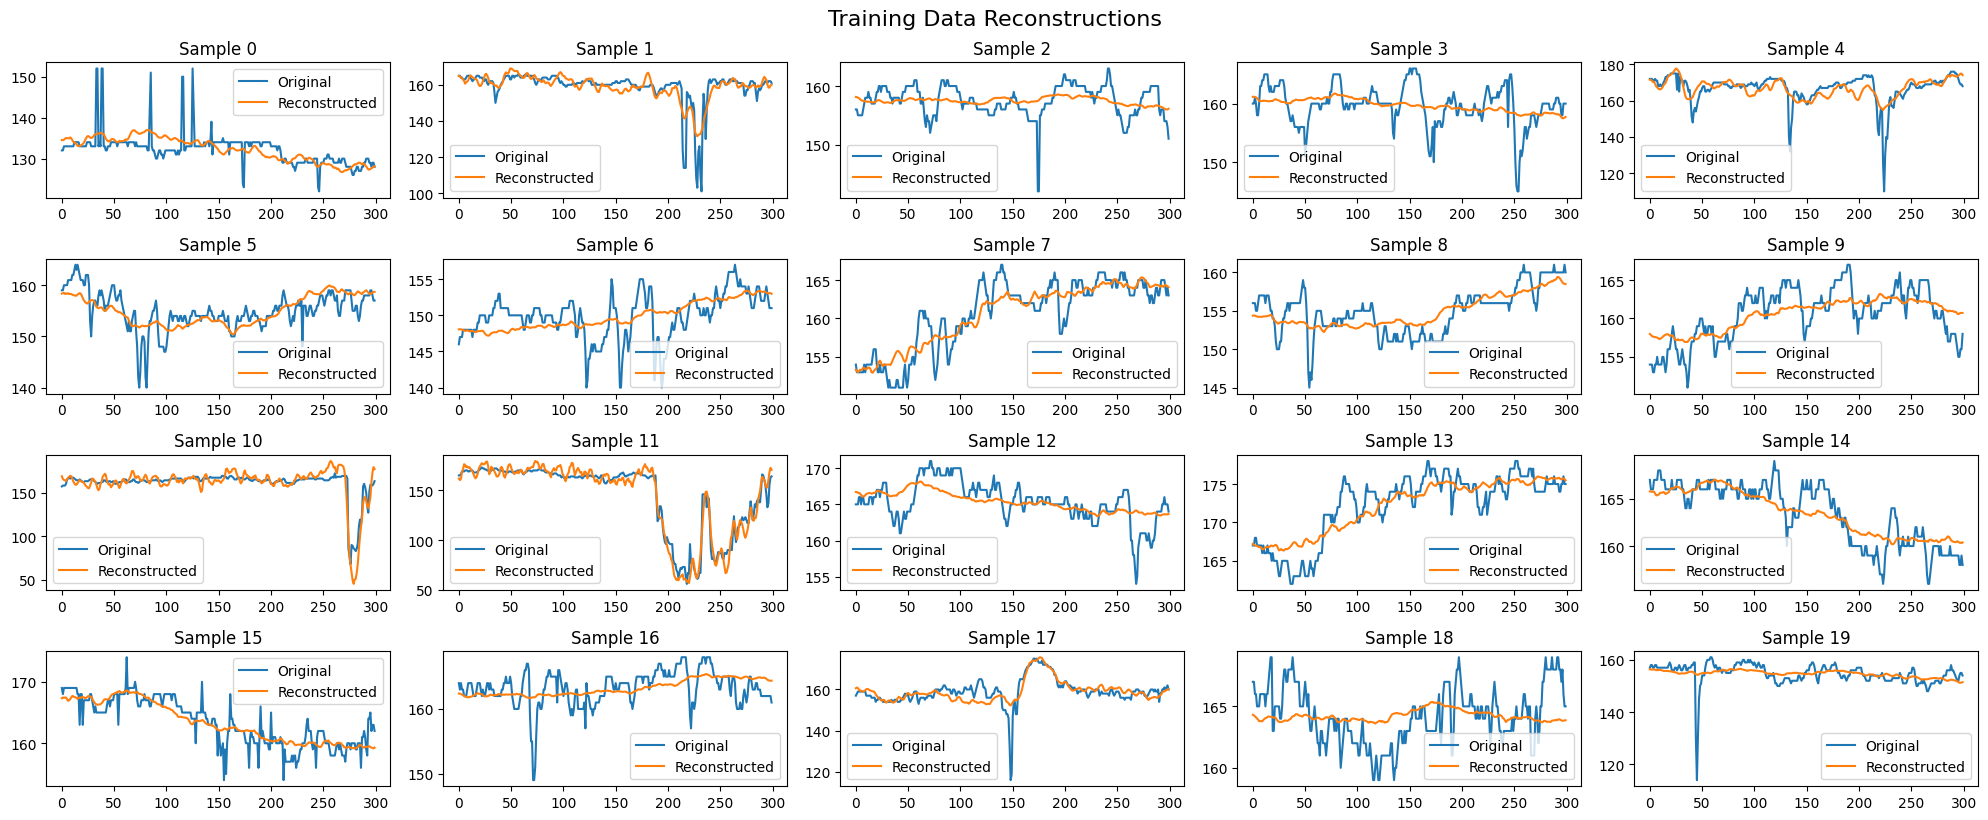

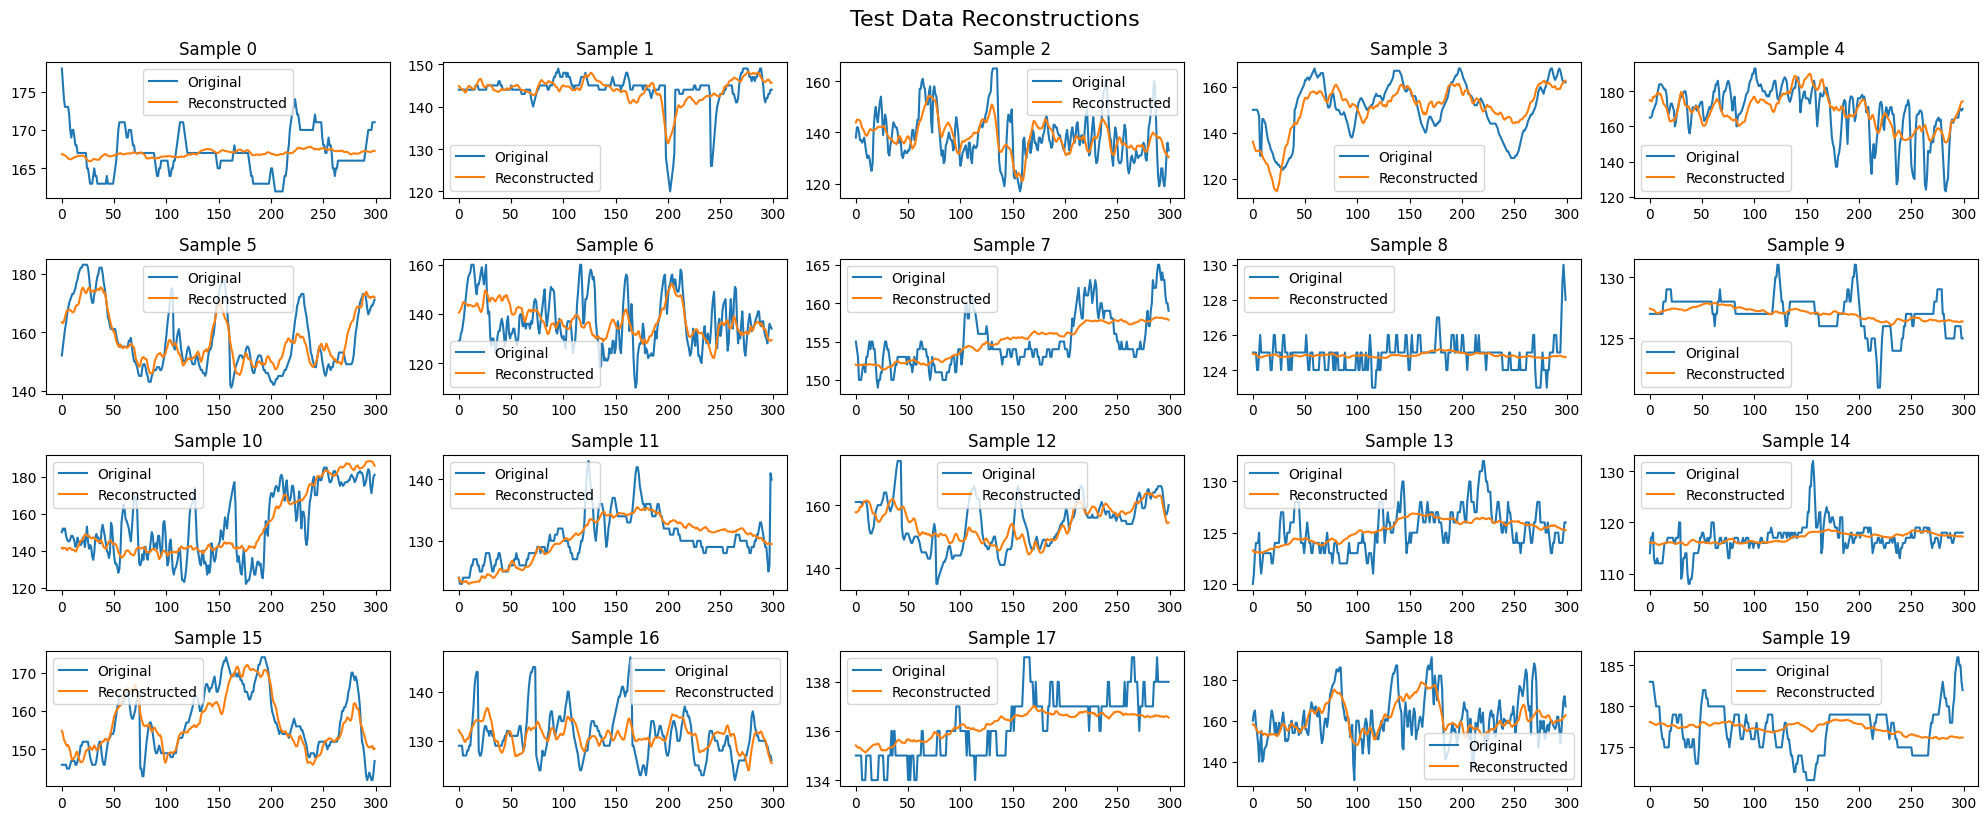

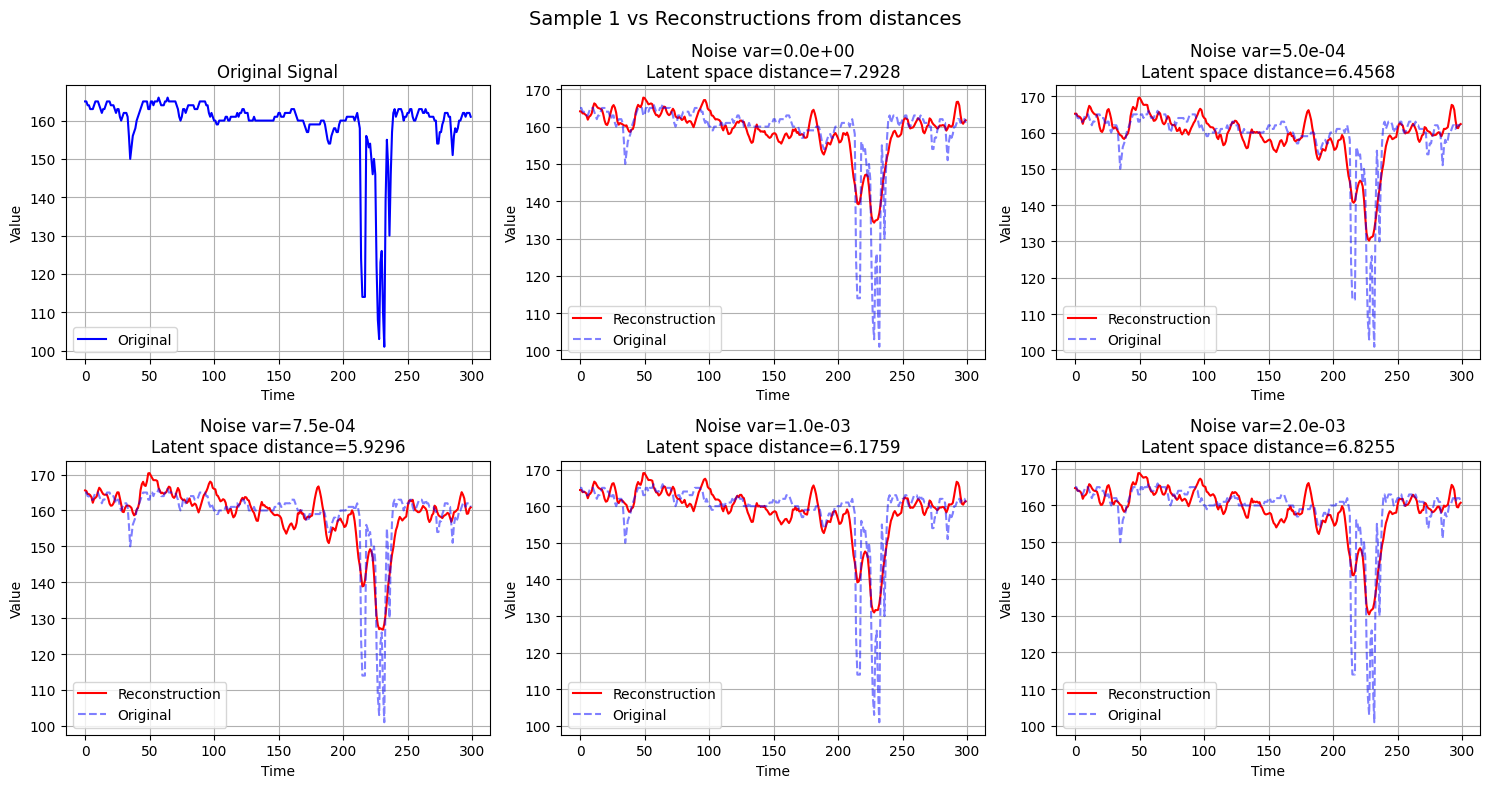

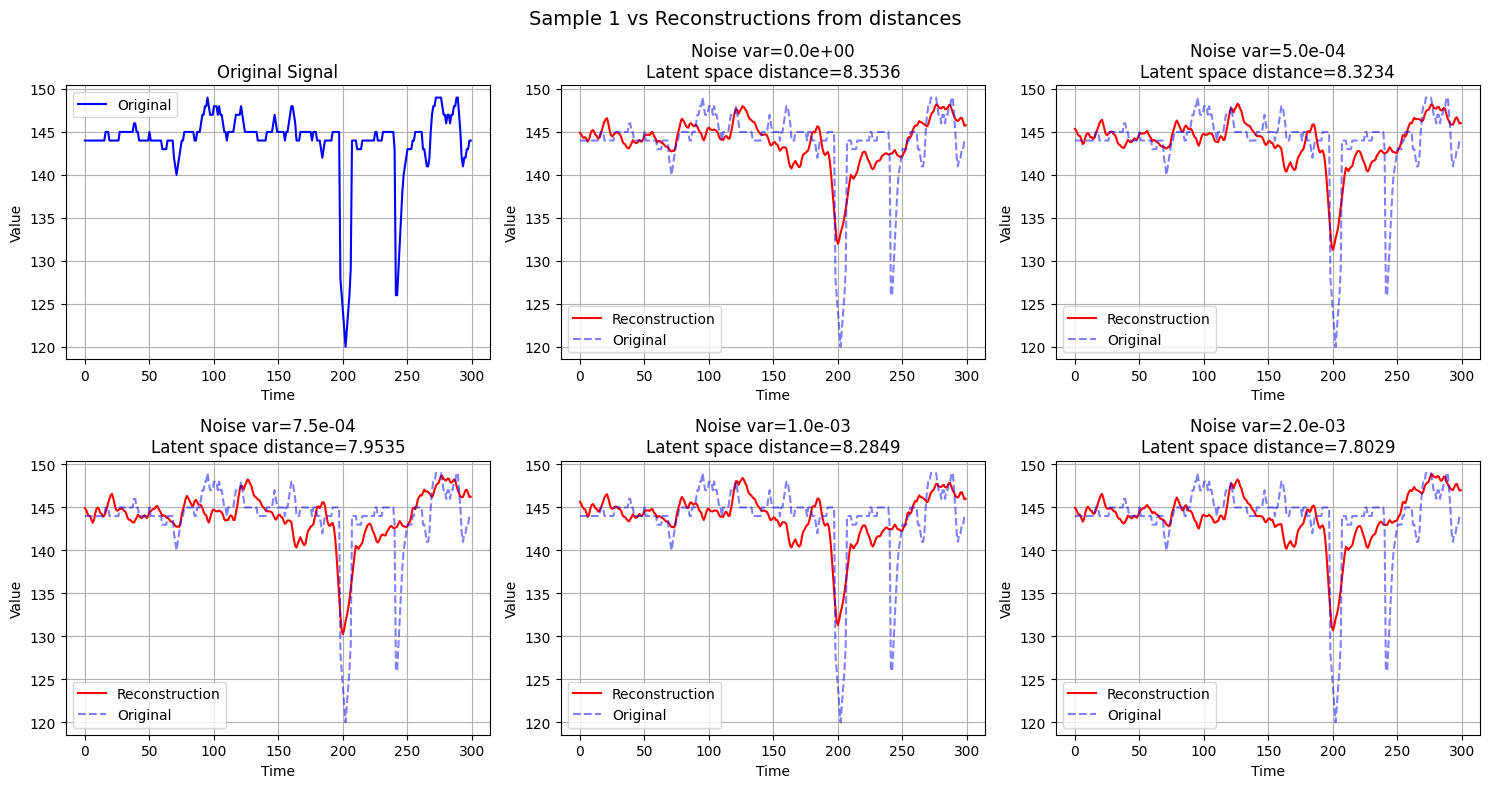

In [7]:
overwrite = False
from_clip = True
if overwrite:
    if from_clip or not os.path.exists(model_path):
        # load model and eval from checkpoint of clip
        model.load_state_dict(torch.load(model_clip_path, map_location=torch.device(device)))
        eval_dict_ts2txt = torch.load(output_dir+'/evals_clip_ts2txt.pth', map_location=torch.device(device))
        eval_dict_txt2ts = torch.load(output_dir+'/evals_clip_txt2ts.pth', map_location=torch.device(device))
        train_losses = eval_dict_ts2txt['train_losses']
        test_losses = eval_dict_ts2txt['test_losses']
        train_eval_metrics_ts2txt_list = eval_dict_ts2txt['train_evals']
        test_eval_metrics_ts2txt_list = eval_dict_ts2txt['test_evals']
        train_eval_metrics_txt2ts_list = eval_dict_txt2ts['train_evals']
        test_eval_metrics_txt2ts_list = eval_dict_txt2ts['test_evals']
    else: 
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        losses = torch.load(output_dir+'/losses.pth', map_location=torch.device(device))
        train_losses = losses['train_losses']
        test_losses = losses['test_losses']
        eval_dict_ts2txt = torch.load(output_dir+'/evals_clip_ts2txt.pth', map_location=torch.device(device))
        eval_dict_txt2ts = torch.load(output_dir+'/evals_clip_txt2ts.pth', map_location=torch.device(device))
        train_eval_metrics_ts2txt_list = eval_dict_ts2txt['train_evals']
        test_eval_metrics_ts2txt_list = eval_dict_ts2txt['test_evals']
        train_eval_metrics_txt2ts_list = eval_dict_txt2ts['train_evals']
        test_eval_metrics_txt2ts_list = eval_dict_txt2ts['test_evals']
    
    # ------------------------- ready training for vae decoder -------------------------
    # 1. Freeze encoders
    for param in model.ts_encoder.parameters():
        param.requires_grad = False
    for param in model.text_encoder.parameters():
        param.requires_grad = False
    # 2. Unfreeze logvar_layer in ts_encoder to trainable
    for param in model.ts_encoder.logvar_layer.parameters():
        param.requires_grad = True
    # 3. Unfreeze decoder
    for param in model.ts_decoder.parameters():
        param.requires_grad = True
    # Verify parameters
    print("Checking trainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}")
    
    # Create optimizer with only trainable parameters
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=200,       
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-3,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=0.0, 
                                end=1.0, 
                                epochs=10000) # for the first 1000 epochs, favor reconstruction more


    
    for i in range(config_dict['num_saves']):  # n_evals
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs']*10, 
                                                        train_type='joint',
                                                        alpha = 1)
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        if config_dict['3d']:
            train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)

        else:
            train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)

        train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
        test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
        eval_dict_ts2txt = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_ts2txt_list,
                    'test_evals': test_eval_metrics_ts2txt_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
        test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
        eval_dict_txt2ts = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_txt2ts_list,
                    'test_evals': test_eval_metrics_txt2ts_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save({'train_losses': train_losses,
                    'test_losses': test_losses}, output_dir+'/losses.pth')
        # torch.save(eval_dict_ts2txt, output_dir+'/evals_ts2txt.pth')
        # torch.save(eval_dict_txt2ts, output_dir+'/evals_txt2ts.pth')
    
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()
    losses = torch.load(output_dir+'/losses.pth', map_location=torch.device(device))
    train_losses = losses['train_losses']
    test_losses = losses['test_losses']
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5, 3))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
    # eval vae
    plot_reconstructions(model, 
                        df=df_train, 
                        config_dict = config_dict, 
                        text_col_ls = config_dict['text_col_ls'],
                        title="Training Data Reconstructions")

    plot_reconstructions(model, 
                        df=df_test, 
                        config_dict = config_dict, 
                        text_col_ls = config_dict['text_col_ls'],
                        title="Test Data Reconstructions")

    plot_reconstruction_from_distances(model, df_train, config_dict, text_col_ls = config_dict['text_col_ls'])
    plot_reconstruction_from_distances(model, df_test, config_dict, text_col_ls = config_dict['text_col_ls'])
    

### Inference

In [8]:
i = 3
distance_ratios = [50]
threshold = 0
K = 10000 # at each given distance ratio, sample K Zs
top = 1000
keep = 1000
poptop = False
df_infer = df_test.copy()
df = df_infer.iloc[[i]].copy()
print(df['text'].to_list()[0])

High amount of consecutive increases.


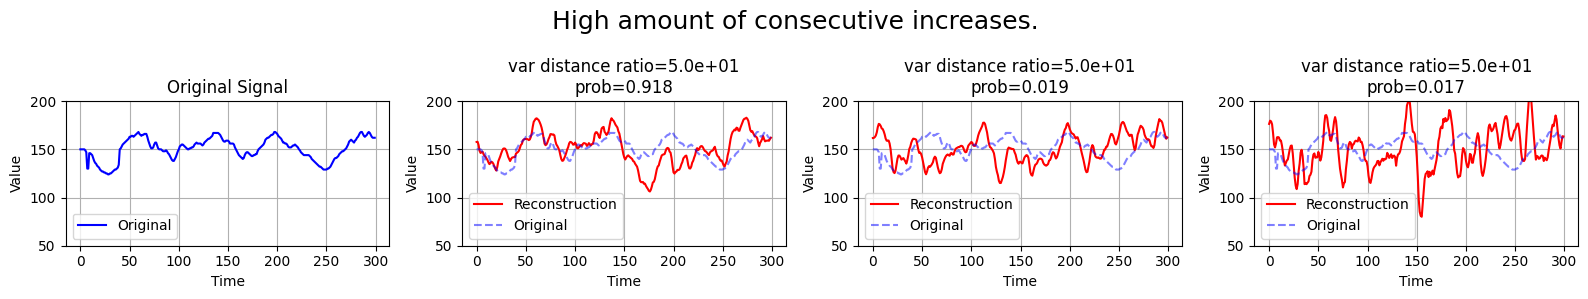

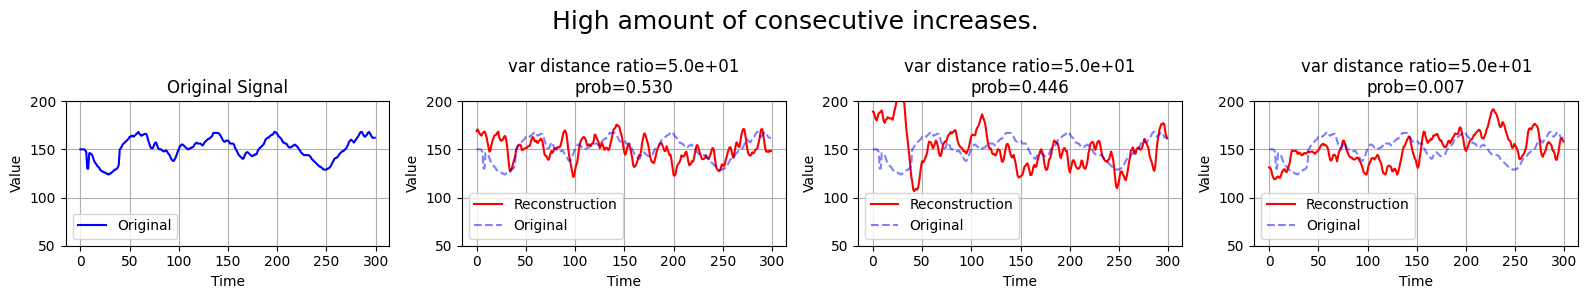

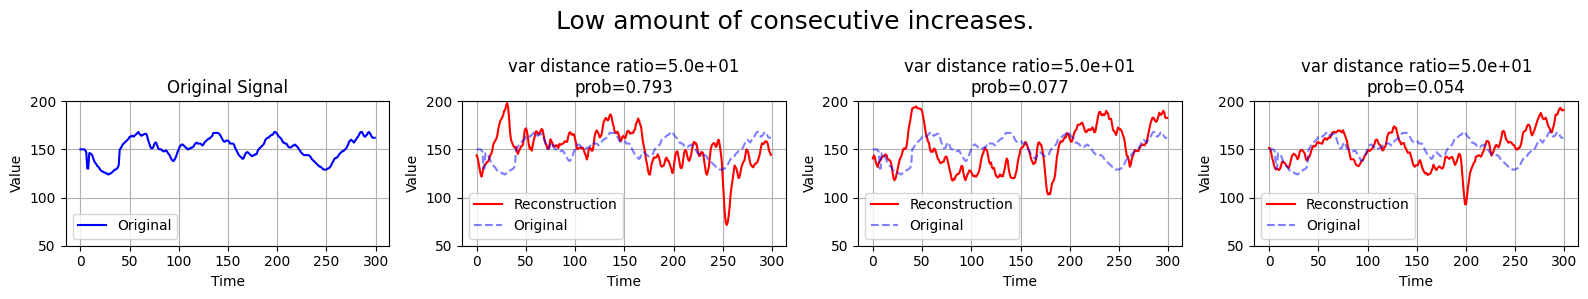

In [9]:
keep = 3
df = df_infer.iloc[[i]].copy()
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                              text_col = 'text',
                                                              # text_col_ls=['cl_event', 'ts_description', 'demo'],
                                                              distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text'].tolist()[0])

df = df_infer.iloc[[i]].copy()
df['text1'] = 'High amount of consecutive increases.'

ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col = 'text1',
                                                              # text_col_ls=['cl_event', 'text1', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0])

df = df_infer.iloc[[i]].copy()
df['text1'] = 'Low amount of consecutive increases.'

ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col = 'text1',
                                                              # text_col_ls=['cl_event', 'text1', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0])


In [30]:
i = 3
distance_ratios = [50, 100, 150]
threshold = 0
K = 10000 # at each given distance ratio, sample K Zs
top = 1000
keep = 1000
poptop = False
df_infer = df_test.copy()
df = df_infer.iloc[[i]].copy()
print(df['text'].to_list()[0])

High amount of consecutive increases.


In [31]:
df = df_infer.iloc[[i]].copy()
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                            text_col = 'text',
                                                            # text_col_ls=['cl_event', 'ts_description', 'demo'],
                                                            K = K,
                                                            top = top,
                                                            distance_ratios = distance_ratios,
                                                            threshold = threshold,
                                                            poptop = poptop,
                                                            keep = keep)
u0 = []
for i in range(len(top_ts_hats)):
    o = successive_increases(top_ts_hats[i].detach().cpu().numpy())
    p = round(top_probs[i].detach().cpu().numpy()*100, 2)
    u = round(o['uuu']*3 + o['uu']*2 + o['u'], 2)
    wu = u*p
    u0.append(u)


df['text1'] = 'High amount of consecutive increases.'
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                            text_col = 'text1',
                                                            # text_col_ls=['cl_event', 'ts_description', 'demo'],
                                                            K = K,
                                                            top = top,
                                                            distance_ratios = distance_ratios,
                                                            threshold = threshold,
                                                            poptop = poptop,
                                                            keep = keep)
u1 = []
for i in range(len(top_ts_hats)):
    o = successive_increases(top_ts_hats[i].detach().cpu().numpy())
    p = round(top_probs[i].detach().cpu().numpy()*100, 2)
    u = round(o['uuu']*3 + o['uu']*2 + o['u'], 2)
    wu = u*p
    u1.append(u)


df['text2'] = 'Low amount of consecutive increases.'
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                            text_col = 'text2',
                                                            # text_col_ls=['cl_event', 'ts_description', 'demo'],
                                                            K = K,
                                                            top = top,
                                                            distance_ratios = distance_ratios,
                                                            threshold = threshold,
                                                            poptop = poptop,
                                                            keep = keep)
u2 = []
for i in range(len(top_ts_hats)):
    o = successive_increases(top_ts_hats[i].detach().cpu().numpy())
    p = round(top_probs[i].detach().cpu().numpy()*100, 2)
    u = round(o['uuu']*3 + o['uu']*2 + o['u'], 2)
    wu = u*p
    u2.append(u)


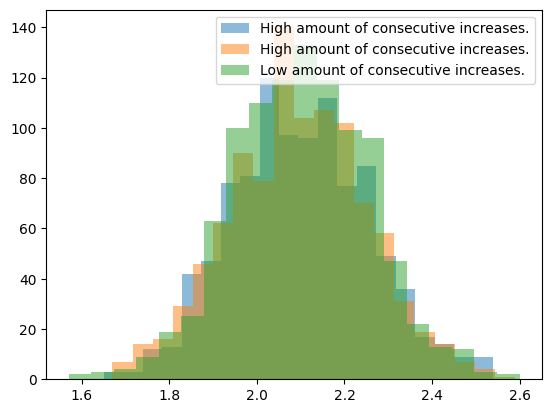

In [32]:
import numpy as np

# Assuming u0, u1, u2 are lists
u0 = np.array(u0)
u1 = np.array(u1)
u2 = np.array(u2)

# Now you can perform the operation
# u0[u0 > 20] = 20
# u1[u1 > 20] = 20
# u2[u2 > 20] = 20
# plot the histogram of u0, u1, u2
plt.hist(u0, bins=20, alpha=0.5, label=df['text'].tolist()[0]) # low (raw)
plt.hist(u1, bins=20, alpha=0.5, label=df['text1'].tolist()[0]) # higher
plt.hist(u2, bins=20, alpha=0.5, label=df['text2'].tolist()[0]) # lower
plt.legend()
plt.show()
